# Model Construction and Hyperparameter Tuning

In [1]:
#import relevant packages
import numpy as np
import pandas as pd
import similarity as sm
import matplotlib.pyplot as plt
import imp
import seaborn as sns
import pickle
imp.reload(sm)

<module 'similarity' from '/notebooks/similarity.py'>

In [2]:
#import data
article_data = pd.read_pickle('ArXiv/articles.pkl')
author_data = pd.read_pickle('ArXiv/authors.pkl')

## Preprocessing Text Data

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .9)

In [4]:
corpus = list(article_data.abstract)

In [5]:
text_vectorized = vectorizer.fit_transform(corpus)

In [6]:
text_vectorized.shape

(1753039, 567327)

Here we attempt to fit a vectorizer to the entire dataset. This will be used to find similar articles by text similarity only. Although the Doc2Vec vectorizer better necodes semantic meaning and therefore produces a better similarity metric, is too computationally expensive to use on the entire dataset. Therefore the vectorizer will allow us to get a rough similarity metric. We will then use Doc2Vec on the most similar subset of these articles to get a more precise similarity metric and produce the actual results of the search.

To visualize the effectiveness of the Tfidf Vector at encoding semantic meaning, we will reduce the vectors to 2 components and plot with color determined by category.

## Visualizing Text Data

In [7]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 2)

In [8]:
text_2d = svd.fit_transform(text_vectorized)

In [9]:
text_2d.shape

(1753039, 2)

In [10]:
categories_new = [categories.split() for categories in article_data.categories]

In [11]:
categories_num = [len(categories) for categories in categories_new]

In [12]:
article_data['x'] = text_2d[:,0]
article_data['y'] = text_2d[:,1]
article_data['categories_new'] = categories_new
article_data['categories_num'] = categories_num

In [13]:
categories_set = list(set([category for categories in article_data.categories_new for category in categories]))
print(len(categories_set))

176


Because there are 176 categories, we will not be able to effectively visualize the distribution of different categories all at once. Further, many articles belong to several categories which would make simultaneous visualization even more complicated. Therefore, we will select a sample of categories to visualize seperately. We may have to simplify things further by taking a sample of the articles as well since it may be hard to distinguish millions of points on a 2d graph.

In [14]:
import random
random.seed(42)
to_plot = random.sample(categories_set, 36)
to_plot

['stat.TH',
 'cs.RO',
 'ao-sci',
 'math.MP',
 'cs.DM',
 'cond-mat.quant-gas',
 'math.RA',
 'stat.ME',
 'nucl-ex',
 'math.KT',
 'math.RT',
 'eess.IV',
 'physics.bio-ph',
 'cs.GR',
 'astro-ph.CO',
 'math.FA',
 'cs.AI',
 'cs.CG',
 'hep-th',
 'math.CO',
 'math.IT',
 'physics.data-an',
 'funct-an',
 'cs.PL',
 'nucl-th',
 'plasm-ph',
 'nlin.CG',
 'q-fin.CP',
 'stat.AP',
 'math.QA',
 'q-bio.PE',
 'physics.atm-clus',
 'physics.chem-ph',
 'physics.space-ph',
 'math.AC',
 'astro-ph.IM']

In [15]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std, **kwargs):
    
    cov = np.cov(x,y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    
    rad_x = np.sqrt(1 + pearson)
    rad_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0,0), width = 2*rad_x, height = 2*rad_y, facecolor = 'none', **kwargs)
    
    scale_x = np.std(x)*n_std
    x_bar = np.mean(x)
    
    scale_y = np.std(y)*n_std
    y_bar = np.mean(y)
    
    transform = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(x_bar, y_bar)
    
    ellipse.set_transform(transform + ax.transData)
    
    return ax.add_patch(ellipse)

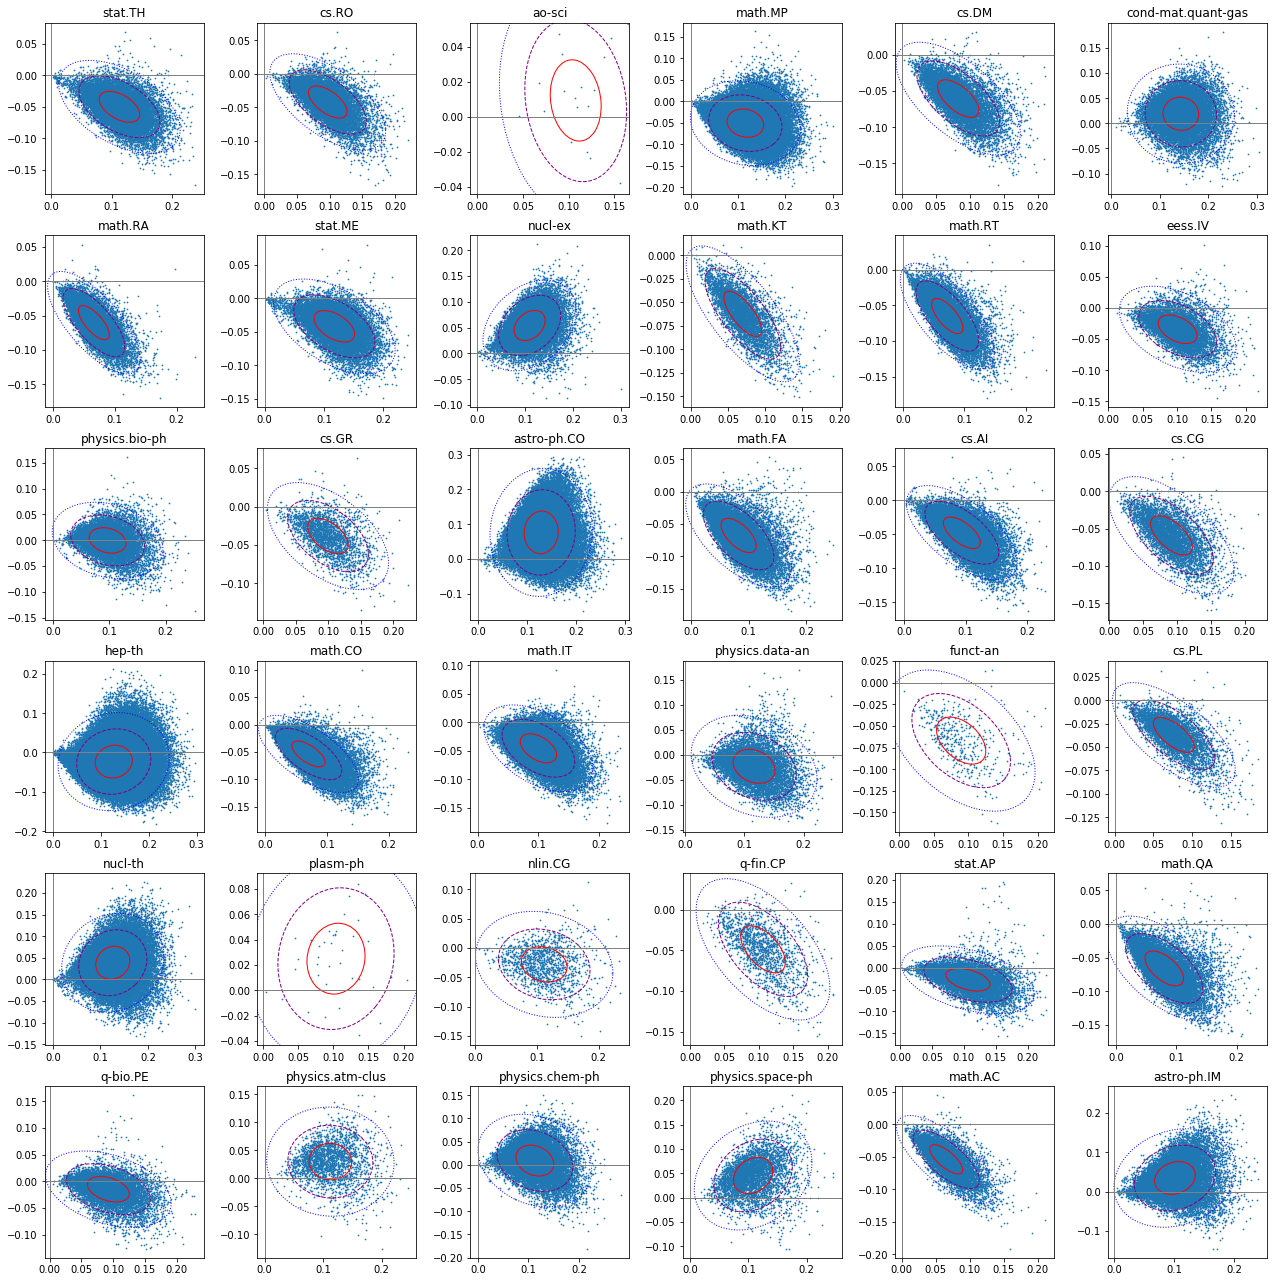

In [16]:
fig, axs = plt.subplots(6, 6, figsize = (18, 18))
fig.tight_layout(pad = 2)
for ax, category in zip(np.ndarray.flatten(axs), to_plot):
    of_interest = [category in categories for categories in article_data.categories_new]
    x = article_data[of_interest].x
    y = article_data[of_interest].y
    
    ax.scatter(x, y, s = 0.5)
    ax.axvline(c = 'grey', lw = 1)
    ax.axhline(c = 'grey', lw = 1)
    confidence_ellipse(x, y, ax, 1, edgecolor = 'red')
    confidence_ellipse(x, y, ax, 2, edgecolor = 'purple', linestyle = '--')
    confidence_ellipse(x, y, ax, 3, edgecolor = 'blue', linestyle = ':')
    
    ax.set_title(category)

There are several interesting observations to be made from the above graphs. Firstly, the different categories are surprisingly well differentiated considering the fact that we reduced a 500,000 dimensional representation down to 2 dimensions. The categories have varying means and distributions, suggesting that some semantic meaning is certainly encoded by the vector representation. Further, articles of the same parent category appear to have distributions which are more alike to each other than they are to articles of another parent category. This provides further encouragement. We also see that the data is densely distributed by category rather than spread out. This suggests that the categories are in fact good indicators of the content of an article. Lastly, one interesting observation is that nearly all of the distributions display negative correlation except for a few physics based categories, which display positive correlations. This indicates that the terminology used in these papers is highly different from the terminology found in most other types of papers samples.


To test the claim that categories encode meaningful information about the content of articles we will break the categories into groups by the parent category. We will then calculate the 95% confidence ellipse for each category and determine the overlap between each set of ellipses. If our hypothesis is correct then categories of the same parent category will have more overlap on average than  categories of different parent categories.

The ArXiv category taxonomy used to determine parent categories may be found <a href=https://arxiv.org/category_taxonomy>here</a>

In [17]:
#create dictionary of categories sorted by parent category
parent_categories = dict()
computer_science = '''cs.AI, cs.AR, cs.CC, cs.CE, cs.CG, cs.CL, cs.CR, cs.CV, cs.CY, cs.DB, cs.DC, cs.DL, cs.DM, cs.DS, cs.ET, cs.FL, cs.GL, cs.GR, cs.GT, cs.HC, cs.IR, cs.IT, cs.LG, cs.LO, cs.MA, cs.MM, cs.MS, cs.NA, cs.NE, cs.NI, cs.OH, cs.OS, cs.PF, cs.PL, cs.RO, cs.SC, cs.SD, cs.SE, cs.SI, cs.SY'''

economics = 'econ.EM, econ.GN, econ.TH'

electrical_engineering_systems = 'eess.AS, eess.IV, eess.SP, eess.SY'

mathematics = '''math.AC, math.AG, math.AP, math.AT, math.CA, math.CO, math.CT, math.CV, math.DG, math.DS, math.FA, math.GM, math.GN, math.GR, math.GT, math.HO, math.IT, math.KT, math.LO, math.MG, math.MP, math.NA, math.NT, math.OA, math.OC, math.PR, math.QA, math.RA, math.RT, math.SG, math.SP, math.ST'''

astro_physics = 'astro-ph.CO, astro-ph.EP, astro-ph.GA, astro-ph.HE, astro-ph.IM, astro-ph.SR'

condensed_matter = '''cond-mat.dis-nn, cond-mat.mes-hall, cond-mat.mtrl-sci, cond-mat.other, cond-mat.quant-gas, cond-mat.soft, cond-mat.stat-mech, cond-mat.str-el, cond-mat.supr-con'''

general_physics = '''physics.acc-ph, physics.ao-ph, physics.app-ph, physics.atm-clus, physics.atom-ph, physics.bio-ph, physics.chem-ph, physics.class-ph, physics.comp-ph, physics.data-an, physics.ed-ph, physics.flu-dyn, physics.gen-ph, physics.hist-ph, physics.ins-det, physics.med-ph, physics.optics, physics.plasm-ph, physics.pop-ph, physics.soc-ph, physics.space-ph'''

other_physics = '''gr-qc, hep-ex, hep-lat, hep-ph, hep-th, math-ph, nlin.AO, nlin.CD, nlin.CG, nlin.PS, nlin.SI, nucl-ex, nucl-th, quant-ph'''

quantitative_biology = '''q-bio.BM, q-bio.CB, q-bio.GN, q-bio.MN, q-bio.NC, q-bio.OT, q-bio.PE, q-bio.QM, q-bio.SC, q-bio.TO'''

quantitative_finance = '''q-fin.CP, q-fin.EC, q-fin.GN, q-fin.MF, q-fin.PM, q-fin.PR, q-fin.RM, q-fin.ST, q-fin.TR'''

statistics = 'stat.AP, stat.CO, stat.ME, stat.ML, stat.OT, stat.TH'

parent_categories['computer_science'] = str.split(computer_science, ', ')
parent_categories['economics'] = str.split(economics, ', ')
parent_categories['electrical_engineering_systems'] = str.split(electrical_engineering_systems, ', ')
parent_categories['mathematics'] = str.split(mathematics, ', ')
parent_categories['astro_physics'] = str.split(astro_physics, ', ')
parent_categories['condensed_matter'] = str.split(condensed_matter, ', ')
parent_categories['general_physics'] = str.split(general_physics, ', ')
parent_categories['other_physics'] = str.split(other_physics, ', ')
parent_categories['quantitative_biology'] = str.split(quantitative_biology, ', ')
parent_categories['quantitative_finance'] = str.split(quantitative_finance, ', ')
parent_categories['statistics'] = str.split(statistics, ', ')



In [18]:
# create dictionary of where categories appear in category set
category_indices = dict()

for parent_category in parent_categories.keys():
    
    indices = [categories_set.index(category) for category in parent_categories[parent_category]]
    indices.sort()
    category_indices[parent_category] = indices

In [19]:
from shapely.geometry.point import Point
from shapely import affinity

In [20]:
#function to create confidence ellipses capable of intersection
def create_ellipse(x,y):
    
    cov = np.cov(x,y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    
    rad_x = np.sqrt(1 + pearson)
    rad_y = np.sqrt(1 - pearson)
    
    scale_x = np.std(x)*2
    x_bar = np.mean(x)
    
    scale_y = np.std(y)*2
    y_bar = np.mean(y)
    
    circ = Point((x_bar, y_bar)).buffer(1)
    ell = affinity.scale(circ, scale_x*rad_x, scale_y*rad_y)
    ellr = affinity.rotate(ell, 45)
    
    return ellr
    

In [21]:
#create ellipse for each category
ellipses = dict()
for category in categories_set:
    
    data = article_data[[category in categories for categories in article_data.categories_new]]
    xs = data.x
    ys = data.y
    
    ellipses[category] = create_ellipse(xs, ys)

In [22]:
#create matrix of pairwise intersections
n = len(categories_set)
intersection_areas = np.empty([n, n])
for i, category_i in enumerate(categories_set):
    for j, category_j in enumerate(categories_set):
        
        ell_i = ellipses[category_i]
        ell_j = ellipses[category_j]
        
        intersection_ij = ell_i.intersection(ell_j)
        
        possible_area = min(ell_i.area, ell_j.area)
        intersection_areas[i, j] = intersection_ij.area / possible_area

In [23]:
#function for intra-parent-category overlap
def within_overlap(index_list):
    
    overlap_areas = list()
    for i, index_i in enumerate(index_list):
        for index_j in index_list[i+1:]:
            overlap_areas.append(intersection_areas[index_i, index_j])
            
    within = sum(overlap_areas) / len(overlap_areas)
    
    return within

In [24]:
#function for inter-parent-category overlap
def without_overlap(index_list1, index_list2):
    
    overlap_areas = list()
    for index_i in index_list1:
        for index_j in index_list2:
            overlap_areas.append(intersection_areas[index_i, index_j])
            
    without = sum(overlap_areas) / len(overlap_areas)
    
    return without

In [25]:
#create matrix of pairwise overlap
overlap_matrix = np.empty((11,11))
withins = list()
withouts = list()

for i, index_list1 in enumerate(category_indices.values()):
    for j, index_list2 in enumerate(category_indices.values()):
        if i == j:
            overlap_matrix[i, j] = within_overlap(index_list1)
            withins.append(within_overlap(index_list1))
            
        else:
            overlap_matrix[i, j] = without_overlap(index_list1, index_list2)
            withouts.append(without_overlap(index_list1, index_list2))

In [26]:
print('Average Overlap Percent of Article Categories from the Same Parent Category:', np.mean(withins))
print('Average Overlap Percent of Article Categories with Different Parent Categories:', np.mean(withouts))

Average Overlap Percent of Article Categories from the Same Parent Category: 0.8009957756983582
Average Overlap Percent of Article Categories with Different Parent Categories: 0.5609121791792023


In [27]:
pd.DataFrame(overlap_matrix, columns = parent_categories.keys(), index = parent_categories.keys())

,computer_science,economics,electrical_engineering_systems,mathematics,astro_physics,condensed_matter,general_physics,other_physics,quantitative_biology,quantitative_finance,statistics
computer_science,0.822708,0.752942,0.836673,0.665260,0.076092,0.393699,0.554053,0.621211,0.686973,0.828733,0.766657
economics,0.752942,0.676908,0.801778,0.540045,0.114519,0.471940,0.654871,0.641293,0.770781,0.811389,0.701401
electrical_engineering_systems,0.836673,0.801778,0.977919,0.574985,0.098999,0.510177,0.625405,0.717062,0.743909,0.853794,0.878634
mathematics,0.665260,0.540045,0.574985,0.821082,0.025774,0.167659,0.312286,0.411963,0.430067,0.600242,0.573147
astro_physics,0.076092,0.114519,0.098999,0.025774,0.751521,0.520098,0.438500,0.387667,0.247863,0.119669,0.093069
condensed_matter,0.393699,0.471940,0.510177,0.167659,0.520098,0.828460,0.739017,0.696362,0.647733,0.477321,0.467775
general_physics,0.554053,0.654871,0.625405,0.312286,0.438500,0.739017,0.767603,0.689359,0.780043,0.625964,0.542304
other_physics,0.621211,0.641293,0.717062,0.411963,0.387667,0.696362,0.689359,0.679754,0.719958,0.659215,0.684248
quantitative_biology,0.686973,0.770781,0.743909,0.430067,0.247863,0.647733,0.780043,0.719958,0.861523,0.751326,0.614382
quantitative_finance,0.828733,0.811389,0.853794,0.600242,0.119669,0.477321,0.625964,0.659215,0.751326,0.806389,0.733884


In [28]:
#Well Defined metric: measures how self similar and dissimilar to others a parent cateogry is
definition = list()
for i in range(11):
    num = overlap_matrix[i, i]
    denom = (sum(overlap_matrix[i,:]) - overlap_matrix[i, i])/10
    
    definition.append(num/denom)

pd.DataFrame(definition, index = parent_categories.keys(), columns = ['Well Defined'])

,Well Defined
computer_science,1.330749
economics,1.081157
electrical_engineering_systems,1.472455
mathematics,1.908859
astro_physics,3.541149
condensed_matter,1.627053
general_physics,1.287535
other_physics,1.091389
quantitative_biology,1.347597
quantitative_finance,1.247983


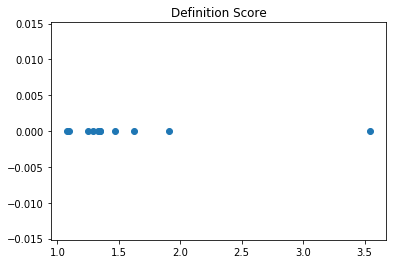

In [29]:
plt.scatter(definition, np.zeros_like(definition))
plt.title('Definition Score')
plt.show()

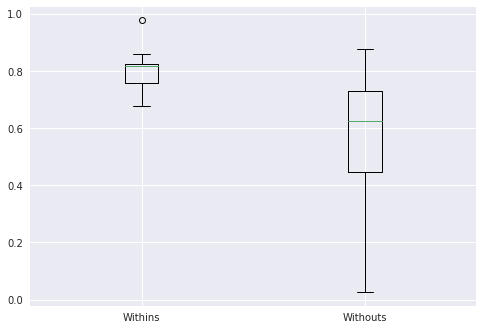

In [30]:
#box plot of intra similarity vs inter similarity
plt.style.use('seaborn')
plt.boxplot([withins, withouts], labels = ['Withins', 'Withouts'])
plt.show()

We can see from the above plot that similarity within the same parent category is not only much higher on average than similarity without, but that the distribution of similarities within the same parent categories is much tighter.

The 'Well Defined' metric divides self similarity by the average of cross category similarity for each parent category. Therefore, parent categories which are highly self similar and highly dissimilar to other categories score higher in this metric. From the metric we see that all of the categories score above 1, meaning that they are all more self similar than similar to other categories on average. 'Economics' and 'Other Physics' are the two least well definied categories. Possible explanations include the low number of 'Economics' subcategories, meaning higher variance in scores, and the fact that the 'Other Physics' category is an amalgam of single category physics parent categories and so cover a wide variety of topics between them, many of which my be shared by 'General Physics'. Aside from these two underperformers, the rest of the parentcategories have a definition score of 1.24 or higher. 

From this we may reasonably conclude that our previous hypotheses were correct and that the category does in fact encode meaningful information about the terminology of an article. Therefore, when crafting our recommender, we may consider recommending only articles which share a category with the original article of interest.

## Recommender Metrics

Before iterating recommender versions, we must first define a scoring systems to compare each iteration with. The score will be based upon the abstracts of the top ten articles returned by each recommender. Each abstract will be rated on a simple similarity scale to the originial article of interest with the recommender receiving the average score of all ten articles.

<table>
    <tr>
        <th>Score</th>
        <th>0</th>
        <th>1</th>
        <th>2</th>
        <th>3</th>
    </tr>  
    <tr>
        <th>Criteria</th>
        <td>Article has no relevance to original article of interest. Returned due to similar notation or key-words. Does not share a general field with the original article. Does not expound upon relevant concepts from the vantage of another field</td>
        <td>Article has slight relevance to the orignial article of interest. May share a similar field with the original article of interest or may explore relevant concepts from an unrelated point of view.</td>
        <td> Article has strong relevance to the original article of interest. Must share a similar field with the original article of interest and explore similar concepts, though perhaps with not the same focus.</td>
        <td> Article is highly relevant to the original article. The field must be the same as the original article of interest. Major key-words from the original article must appear. The article is examining nearly the same question or a corrolary of the original question.</td>
    </tr>    
</table>

## Vectorize by Category

In [31]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .9)
category_vectorized = dict()

In [32]:
for category in categories_set:
    
    of_interest = [category in categories for categories in article_data.categories_new]
    articles_of_interest = article_data[of_interest]
    
    corpus = list(articles_of_interest.abstract)
    
    category_vectorized[category] = vectorizer.fit_transform(corpus)

In [33]:
article_dictionary = dict()

for category in categories_set:
    
    of_interest = [category in categories for categories in article_data.categories_new]
    
    article_dictionary[category] = article_data[of_interest]
    
    article_dictionary[category].reset_index(inplace = True)

## Tfidf Similarity

In [34]:
def cosine_similarity(from_ids, text_vectorized, articles):
    
    N = text_vectorized.shape[0]
    M = len(from_ids)
    similarity_array = np.empty((N,M))

    for i in range(M):
        
        index = list(articles[articles.id == from_ids[i]].index)[0]
    
        similarity = np.dot(text_vectorized, text_vectorized[index].T)
        similarity = similarity.todense()
        similarity += 1
        similarity_array[:, i] = np.squeeze(similarity)
    
    similarity_score = M / np.sum(1/similarity_array, axis = 1)
    similarity_score += -1
    
    return similarity_score

In [35]:
id1 = '0704.0002'
list(article_data[article_data.id == id1].categories_new)[0]

['math.CO', 'cs.CG']

In [36]:
def text_similarity(from_ids, vector_dictionary, article_dictionary):
    
    categories_list = list()
    for article_id in from_ids:
        categories_list += list(article_data[article_data.id == article_id].categories_new)[0]
        
    categories_list = list(set(categories_list))
    
    recommended = dict()
    
    for category in categories_list:
        
        articles = article_dictionary[category]
        text_vectorized = vector_dictionary[category]
        
        indices = articles[articles['id'].isin(from_ids)].index
    
        df = pd.DataFrame()
        df['id'] = articles.id
        df['similarity_score'] = cosine_similarity(from_ids, text_vectorized, articles)
        
        df.sort_values(by = 'similarity_score', ascending = False, inplace = True)
        df.drop(indices, inplace = True)
        recommended[category] = df.head(10)
    
    recommendations = pd.concat(recommended.values())
    recommendations.sort_values(by = 'similarity_score', ascending = False, inplace = True)
    recommendations.drop_duplicates(subset = ['id'], keep = 'first', inplace = True)
    
    return recommendations.head(10)

## Tfidf Test Similarity

In [37]:
article_data[article_data.id == '0704.0002']

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,...,versions,update_date,authors_parsed,num_authors,authors_new,abstract_length,x,y,categories_new,categories_num
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,"[streinuileana, theranlouis]",107,0.076635,-0.070532,"[math.CO, cs.CG]",2


In [38]:
list(article_data[article_data.id == '0704.0002'].abstract)[0]

'  We describe a new algorithm, the $(k,\\ell)$-pebble game with colors, and use\nit obtain a characterization of the family of $(k,\\ell)$-sparse graphs and\nalgorithmic solutions to a family of problems concerning tree decompositions of\ngraphs. Special instances of sparse graphs appear in rigidity theory and have\nreceived increased attention in recent years. In particular, our colored\npebbles generalize and strengthen the previous results of Lee and Streinu and\ngive a new proof of the Tutte-Nash-Williams characterization of arboricity. We\nalso present a new decomposition that certifies sparsity based on the\n$(k,\\ell)$-pebble game with colors. Our work also exposes connections between\npebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and\nWestermann and Hendrickson.\n'

We will start by finding textually similar articles to the one above based on the abstract. This article has been selected because it contains a very specific vocabulary ('sparsity', 'rigidity', 'pebble-games', etc). Therefore, similar articles ought to deal with these topics as well, so it will be easier to evaluate how our similarity function performs.

In [39]:
results = text_similarity(['0704.0002'], category_vectorized, article_dictionary)

In [40]:
results

,id,similarity_score
45789,math/0703921,0.395500
4668,math/0702129,0.380301
22283,1604.05510,0.290300
45891,math/9508218,0.284700
915,1208.5289,0.256563
17238,1411.0923,0.249514
373,0707.4256,0.248299
290,0706.4417,0.232666
23006,1606.08532,0.226586
9228,1204.0503,0.222625


In [41]:
for ID in results.id:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  math/0703921
Authors:  Ileana Streinu and Louis Theran

Abstract: 
  A hypergraph $G=(V,E)$ is $(k,\ell)$-sparse if no subset $V'\subset V$ spans
more than $k|V'|-\ell$ hyperedges. We characterize $(k,\ell)$-sparse
hypergraphs in terms of graph theoretic, matroidal and algorithmic properties.
We extend several well-known theorems of Haas, Lov{\'{a}}sz, Nash-Williams,
Tutte, and White and Whiteley, linking arboricity of graphs to certain counts
on the number of edges. We also address the problem of finding
lower-dimensional representations of sparse hypergraphs, and identify a
critical behaviour in terms of the sparsity parameters $k$ and $\ell$. Our
constructions extend the pebble games of Lee and Streinu from graphs to
hypergraphs.


--------------------

ID:  math/0702129
Authors:  Audrey Lee and Ileana Streinu

Abstract: 
  A multi-graph $G$ on $n$ vertices is $(k,\ell)$-sparse if every subset of
$n'\leq n$ vertices spans at most $kn'- \ell$ edges. $G$ is {\em tight} if, in
add

### Scores:

<table>
    <tr style = 'text-align: left'>
        <th>Article Number</th>
        <th>1</th>
        <th>2</th>
        <th>3</th>
        <th>4</th>
        <th>5</th>
        <th>6</th>
        <th>7</th>
        <th>8</th>
        <th>9</th>
        <th>10</th>
    </tr>
    <tr>
        <th>Score</th>
        <td>3</td>
        <td>3</td>
        <td>2</td>
        <td>1</td>
        <td>0</td>
        <td>2</td>
        <td>2</td>
        <td>0</td>
        <td>1</td>
        <td>2</td>
    </tr>
    <tr>
        <th>Notes</th>
        <td>Pebble Games on Sparse Graphs. Shared Authors.</td>
        <td>Pebble Games on Sparse Graphs. Shared Authors.</td>
        <td>Pebble Game Graph Coloring. Different Approach.</td>
        <td>Pebble Game Algorithm Optimization.</td>
        <td>Unrelated topic. Recommended due to notation.</td>
        <td>Pebble Game on Graphs</td>
        <td>Pebble Game on Graphs</td>
        <td>Unrelated topic. Recommended due to notation</td>
        <td>Cycles on Graphs.</td>
        <td>Coloring of Sparse Graphs.</td>
    </tr>    
</table>

#### Overall Score: 1.6

## Doc2Vec Similarity

In [42]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
import string

In [43]:
category_doc2vec = dict()
for category in categories_set:
    
    of_interest = [category in categories for categories in article_data.categories_new]
    articles_of_interest = article_data[of_interest]
    
    corpus = list(articles_of_interest.abstract)
    corpus = [TaggedDocument(words, [i]) for i, words in enumerate(corpus)]
    
    model = Doc2Vec(corpus, min_count = 1)
    
    category_doc2vec[category] = model
    print(category)

physics.atom-ph
q-fin.ST
stat.CO
math.OA
math.QA
stat.TH
cs.IR
hep-th
cs.HC
cond-mat.supr-con
gr-qc
cs.GR
mtrl-th
q-fin.CP
alg-geom
math.CV
ao-sci
nlin.PS
cond-mat.other
cs.RO
cs.MS
nlin.CG
cs.DM
math.AG
cs.NA
math.CA
patt-sol
nlin.CD
cs.CY
cs.CE
cs.LO
physics.comp-ph
acc-phys
physics.pop-ph
physics.hist-ph
math-ph
physics.acc-ph
cs.SD
math.MG
cs.DB
math.DG
physics.plasm-ph
physics.atm-clus
q-fin.TR
chao-dyn
cmp-lg
math.ST
quant-ph
math.PR
math.LO
math.HO
cs.NI
q-bio.GN
q-fin.PR
stat.ML
math.GT
math.RA
math.MP
math.OC
cond-mat.mes-hall
q-bio.BM
cs.CV
q-fin.MF
hep-ex
physics.ao-ph
astro-ph.CO
math.CO
q-bio.TO
physics.soc-ph
math.GM
physics.gen-ph
solv-int
cond-mat.stat-mech
cs.FL
math.DS
nucl-th
cs.GT
cond-mat.str-el
q-bio.OT
q-fin.PM
physics.space-ph
eess.SP
q-fin.EC
math.SP
math.AT
cs.SY
cs.AI
physics.chem-ph
physics.ins-det
cs.CR
cond-mat
q-bio.MN
math.AC
astro-ph.EP
cs.OH
physics.data-an
hep-ph
physics.ed-ph
cs.PL
astro-ph.GA
q-fin.GN
econ.EM
eess.SY
plasm-ph
cs.IT
cs.OS
cs.SI
astro

Note: The above vectorization took about an hour an a half. While this is certainly not a crippling amount of time, given that the ArXiv dataset is frequently updated and that the tfidf vectorizer took only a couple minutes, this will have to be taken into account when evaluating performance.

In [55]:
with open('ArXiv/doc2vec.pkl', 'wb') as handle:
    pickle.dump(category_doc2vec, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [43]:
with open('ArXiv/doc2vec.pkl', 'rb') as handle:
    data = pickle.load(handle)

In [44]:
category_doc2vec = data

In [45]:
def doc2vec_similarity(from_ids, vector_dictionary, article_dictionary):
    
    categories_list = list()
    for article_id in from_ids:
        categories_list += list(article_data[article_data.id == article_id].categories_new)[0]
        
    categories_list = list(set(categories_list))
    
    recommended = dict()
    
    for category in categories_list:
        
        articles = article_dictionary[category]
        text_vectorized = vector_dictionary[category].docvecs.vectors_docs
        
        indices = articles[articles['id'].isin(from_ids)].index
    
        df = pd.DataFrame()
        df['id'] = articles.id
        
        scores = np.array([np.dot(text_vectorized, text_vectorized[i].T) for i in indices])
        scores = scores.shape[0]/np.sum(1/scores, axis = 0)
        scores = scores.T
        
        df['similarity_score'] = scores
        
        df.sort_values(by = 'similarity_score', ascending = False, inplace = True)
        df.drop(indices, inplace = True)
        recommended[category] = df.head(10)
    
    recommendations = pd.concat(recommended.values())
    recommendations.sort_values(by = 'similarity_score', ascending = False, inplace = True)
    recommendations.drop_duplicates(subset = ['id'], keep = 'first', inplace = True)
    
    return recommendations.head(10)

## Doc2Vec Test Similarity

In [46]:
results = doc2vec_similarity(['0704.0002'], category_doc2vec, article_dictionary)

In [47]:
results

,id,similarity_score
16248,1407.5336,1.734031
15609,1405.2424,1.458850
16408,1408.1461,1.285238
40742,2008.01961,1.285011
12184,1304.4626,1.283994
10310,1209.1262,1.245530
7352,1107.2677,1.245065
30440,1805.06277,1.244856
38604,2003.03036,1.242954
16507,1408.4290,1.238669


In [48]:
for ID in results.id:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  1407.5336
Authors:  Edouard Bonnet, Florent Foucaud, Eun Jung Kim, Florian Sikora

Abstract: 
  The Grundy number of a graph is the maximum number of colors used by the
greedy coloring algorithm over all vertex orderings. In this paper, we study
the computational complexity of GRUNDY COLORING, the problem of determining
whether a given graph has Grundy number at least $k$. We also study the
variants WEAK GRUNDY COLORING (where the coloring is not necessarily proper)
and CONNECTED GRUNDY COLORING (where at each step of the greedy coloring
algorithm, the subgraph induced by the colored vertices must be connected).
  We show that GRUNDY COLORING can be solved in time $O^*(2.443^n)$ and WEAK
GRUNDY COLORING in time $O^*(2.716^n)$ on graphs of order $n$. While GRUNDY
COLORING and WEAK GRUNDY COLORING are known to be solvable in time
$O^*(2^{O(wk)})$ for graphs of treewidth $w$ (where $k$ is the number of
colors), we prove that under the Exponential Time Hypothesis (ETH), they cannot
be

### Scores:

<table>
    <tr style = 'text-align: left'>
        <th>Article Number</th>
        <th>1</th>
        <th>2</th>
        <th>3</th>
        <th>4</th>
        <th>5</th>
        <th>6</th>
        <th>7</th>
        <th>8</th>
        <th>9</th>
        <th>10</th>
    </tr>
    <tr>
        <th>Score</th>
        <td>2</td>
        <td>1</td>
        <td>0</td>
        <td>0</td>
        <td>1</td>
        <td>2</td>
        <td>0</td>
        <td>1</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <th>Notes</th>
        <td>Graph Colorings. </td>
        <td>Graph Theory</td>
        <td>Unrelated Topic. Search Algorithm.</td>
        <td>Unrelated Topic. Number Theory.</td>
        <td>Graph Theory. Algorithm Optimization.</td>
        <td>Graph Colorings.</td>
        <td>Unrelated Topic. Encryptions.</td>
        <td>Graph Theory.</td>
        <td>Unrelated Topic. Abstract Algebra.</td>
        <td>Unrelated Topic. Particle Physics.</td>
    </tr>    
</table>

#### Overall Score: 0.7

## Doc2Vec Cosine Similarity

In [55]:
def doc2vec_cosine_similarity(from_ids, vector_dictionary, article_dictionary):
    
    categories_list = list()
    for article_id in from_ids:
        categories_list += list(article_data[article_data.id == article_id].categories_new)[0]
        
    categories_list = list(set(categories_list))
    
    recommended = dict()
    
    for category in categories_list:
        
        articles = article_dictionary[category]
        text_vectorized = vector_dictionary[category].docvecs.vectors_docs
        normed_vectors = [text_vectorized[i]/np.sqrt(sum(text_vectorized[i]**2)) for i in range(text_vectorized.shape[0])]
        
        indices = articles[articles['id'].isin(from_ids)].index
    
        df = pd.DataFrame()
        df['id'] = articles.id
        
        scores = np.array([np.dot(normed_vectors, normed_vectors[i].T) for i in indices])
        scores = scores.shape[0]/np.sum(1/scores, axis = 0)
        scores = scores.T
        
        df['similarity_score'] = scores
        
        df.sort_values(by = 'similarity_score', ascending = False, inplace = True)
        df.drop(indices, inplace = True)
        recommended[category] = df.head(10)
    
    recommendations = pd.concat(recommended.values())
    recommendations.sort_values(by = 'similarity_score', ascending = False, inplace = True)
    recommendations.drop_duplicates(subset = ['id'], keep = 'first', inplace = True)
    
    return recommendations.head(10)

In [56]:
results = doc2vec_cosine_similarity(['0704.0002'], category_doc2vec, article_dictionary)

In [57]:
results

,id,similarity_score
6544,1103.1148,0.827775
39490,2005.04135,0.827154
13962,1311.1994,0.823122
3987,0911.4617,0.821618
6650,1103.4629,0.818766
2752,0903.3151,0.817684
2391,0812.3566,0.817455
4087,0912.2438,0.817268
37530,1912.03809,0.816601
15888,1406.2182,0.814988


In [58]:
for ID in results.id:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  1103.1148
Authors:  Michele Vergne

Abstract: 
  Using the Guichardet construction, we compute the cohomology groups of a
complex of free Lie algebras introduced by Alekseev and Torossian.


--------------------

ID:  2005.04135
Authors:  Jacob Fox, Yuval Wigderson, Yufei Zhao

Abstract: 
  We present a short new proof of the canonical polynomial van der Waerden
theorem, recently established by Girao [arXiv:2004.07766].


--------------------

ID:  1311.1994
Authors:  Xin Zhang

Abstract: 
  We introduce the concept of NIC-planar graphs and present the full
characterization of NIC-planar complete k-partite graphs.


--------------------

ID:  0911.4617
Authors:  P. Zinn-Justin

Abstract: 
  We describe a new conjecture involving Fully Packed Loop counting which
relates recent observations of Thapper to formulae in the Temperley--Lieb model
of loops, and how it implies the Razumov--Stroganov conjecture.


--------------------

ID:  1103.4629
Authors:  Nathan Reff

Abstract: 
  We o

### Scores:

<table>
    <tr style = 'text-align: left'>
        <th>Article Number</th>
        <th>1</th>
        <th>2</th>
        <th>3</th>
        <th>4</th>
        <th>5</th>
        <th>6</th>
        <th>7</th>
        <th>8</th>
        <th>9</th>
        <th>10</th>
    </tr>
    <tr>
        <th>Score</th>
        <td>0</td>
        <td>0</td>
        <td>1</td>
        <td>0</td>
        <td>1</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <th>Notes</th>
        <td>Unrelated Topic. </td>
        <td>Unrelated Topic.</td>
        <td>Graph Theory</td>
        <td>Unrelated Topic.</td>
        <td>Graph Theory. </td>
        <td>Unrelated Topic.</td>
        <td>Unrelated Topic.</td>
        <td>Unrelated Topic.</td>
        <td>Unrelated Topic.</td>
        <td>Unrelated Topic.</td>
    </tr>    
</table>

#### Overall Score: 0.2

## Hybrid Approach

In [49]:
def hybrid_similarity(from_ids, vector_dictionary, article_dictionary):
    
    categories_list = list()
    for article_id in from_ids:
        categories_list += list(article_data[article_data.id == article_id].categories_new)[0]
        
    categories_list = list(set(categories_list))
    
    tfidf_recommended = dict()
    
    for category in categories_list:
        
        articles = article_dictionary[category]
        text_vectorized = vector_dictionary[category]
    
        df = pd.DataFrame()
        df['id'] = articles.id
        df['similarity_score'] = cosine_similarity(from_ids, text_vectorized, articles)
        
        df.sort_values(by = 'similarity_score', ascending = False, inplace = True)
        tfidf_recommended[category] = df.head(100)
    
    tfidf_recommendations = pd.concat(tfidf_recommended.values())
    tfidf_recommendations.sort_values(by = 'similarity_score', ascending = False, inplace = True)
    tfidf_recommendations.drop_duplicates(subset = ['id'], keep = 'first', inplace = True)
    tfidf_recommendations.reset_index(inplace = True)
    
    indices = tfidf_recommendations[tfidf_recommendations['id'].isin(from_ids)].index
    
    of_interest = list(tfidf_recommendations.id)
    articles_of_interest = article_data[article_data['id'].isin(of_interest)]
    
    corpus = list(articles_of_interest.abstract)
    corpus = [TaggedDocument(words, [i]) for i, words in enumerate(corpus)]
    
    model = Doc2Vec(corpus, min_count = 1)
    
    hybrid_recommendations = pd.DataFrame()
    hybrid_recommendations['id'] = of_interest
    
    hybrid_vectors = model.docvecs.vectors_docs
    normed_vectors = [hybrid_vectors[i]/np.sqrt(sum(hybrid_vectors[i]**2)) for i in range(hybrid_vectors.shape[0])]
    
    scores = np.array([np.dot(normed_vectors, normed_vectors[i].T) for i in indices])
    scores = scores.shape[0]/np.sum(1/scores, axis = 0)
    scores = scores.T
    
    hybrid_recommendations['similarity_score'] = scores
    hybrid_recommendations.drop(indices, inplace = True)
    
    hybrid_recommendations.sort_values(by = 'similarity_score', ascending = False, inplace = True)
    
    
    return hybrid_recommendations.head(10)

## Hybrid Test Similarity

In [50]:
results = hybrid_similarity(['0704.0002'], category_vectorized, article_dictionary)

In [51]:
results

,id,similarity_score
144,1209.2308,0.996926
15,1709.04079,0.996698
50,1903.05256,0.996096
17,1109.3508,0.996036
56,1210.2621,0.995920
48,1511.09327,0.995816
77,1507.03495,0.995515
62,1508.07299,0.995308
191,1312.2185,0.995285
52,1310.2783,0.995264


In [52]:
for ID in results.id:
    print('ID: ', ID)
    print('Authors: ', list(article_data[article_data.id == ID].authors)[0])
    print()
    print('Abstract: ')
    print(list(article_data[article_data.id == ID].abstract)[0])
    print()
    print('--------------------')
    print()

ID:  1209.2308
Authors:  Subir Kumar Ghosh and Bodhayan Roy

Abstract: 
  In this paper, we present three necessary conditions for recognizing point
visibility graphs. We show that this recognition problem lies in PSPACE. We
state new properties of point visibility graphs along with some known
properties that are important in understanding point visibility graphs. For
planar point visibility graphs, we present a complete characterization which
leads to a linear time recognition and reconstruction algorithm.


--------------------

ID:  1709.04079
Authors:  J\'ozsef Balogh and Lina Li

Abstract: 
  An $r$-uniform \textit{linear cycle} of length $\ell$, denoted by
$C_{\ell}^r$, is an $r$-graph with edges $e_1, \ldots, e_{\ell}$ such that for
every $i\in [\ell-1]$, $|e_i\cap e_{i+1}|=1$, $|e_{\ell}\cap e_1|=1$ and
$e_i\cap e_j=\emptyset$ for all other pairs $\{i, j\},\ i\neq j$. For every
$r\geq 3$ and $\ell\geq 4$, we show that there exists a constant $C$ depending
on $r$ and $\ell$ such

### Scores:

<table>
    <tr style = 'text-align: left'>
        <th>Article Number</th>
        <th>1</th>
        <th>2</th>
        <th>3</th>
        <th>4</th>
        <th>5</th>
        <th>6</th>
        <th>7</th>
        <th>8</th>
        <th>9</th>
        <th>10</th>
    </tr>
    <tr>
        <th>Score</th>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>0</td>
        <td>0</td>
        <td>2</td>
        <td>3</td>
        <td>1</td>
        <td>2</td>
    </tr>
    <tr>
        <th>Notes</th>
        <td>Graph Theory. </td>
        <td>Graph Theory.</td>
        <td>Graph Theory.</td>
        <td>Graph Theory.</td>
        <td>Unrelated. Recommended due to notation.</td>
        <td>Unrelated. Recommended due to notation.</td>
        <td>Graph Coloring.</td>
        <td>Graph Pebbling Algorithm. </td>
        <td>Graph Theory. </td>
        <td>Graph Coloring.</td>
    </tr>    
</table>

#### Overall Score: 1.2

## Model Selection

Of the iterations above, the original Tfidf Vectorizer produced the best results by our metric. This vectorizer returned the most relevant articles with only a few articles recommended due to notation. The Doc2Vec vectorizer returned articles of the same general category or irrelevant articles, but no articles of specific relevance to the original article. When using cosine similarity rather than dot product, the Doc2Vec vectorizer seems to return articles with the shortest possible abstracts and almost none have any relevance to the original article. The hybrid approach of ranking by the Tfidf vectorizer and then using Doc2Vec on the top 100 to choose the top ten recommendations yielded better results than the other two Doc2Vec approaches, but still failed to return articles as relevant as the Tfidf vectorizer.